In [3]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv
import shutil
import gc

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize, ndimage
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import math
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.freesurfer.utils import MakeAverageSubject
from nipype.interfaces.fsl import ExtractROI
from nipype.interfaces.fsl import Merge
from nipype.interfaces.fsl import TOPUP
from nipype.interfaces.fsl import ApplyTOPUP
from nipype.workflows.fmri.fsl import create_susan_smooth

from nilearn import input_data
import nilearn.decoding
import lyman

from surfer import Brain
%matplotlib inline

In [4]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
exp_list = ['ser','sim']

In [5]:
tr = 1.5
frames = np.arange(-1, 6) #number of frames to hold onto
cond_map = {'state':True,'not':False}  
all_rois = {'ser':["lOFC_fill_ser", "mOFC_fill_ser"],'sim':["lOFC_fill_sim", "mOFC_fill_sim"]}

In [4]:
##add a column to the timing file coding for the TR in which an event occured
def get_event_times(sub,exp):
    event_file = home_dir + 'data/' + sub + '/design/' + exp + '_state.csv'
    timing = pd.read_csv(event_file)
    timing =  timing.sort(['run','onset'])
    for run in range(1,4):
        event_time = timing.loc[timing['run']==run,'onset'].values
        tr_index = map(lambda x: int(math.floor(x/tr)),event_time)
        timing.loc[timing['run']==run,'tr_index'] = tr_index
    
    return timing

In [5]:
def load_data(sub,exp, roi):
    all_data = {}
    for run in range(1,4):
#         func_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + str(run) + '/unsmoothed_timeseries.nii.gz'
        func_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/reg/epi/unsmoothed/run_' + str(run) + '/timeseries_xfm.nii.gz'

        if os.path.exists(func_f):
            #data files
            mask_f = home_dir + 'data/' + sub + '/masks/' + roi + '.nii.gz'
            mask_img = nib.load(mask_f)
            
            #load data and detrend
            nifti_masker = input_data.NiftiMasker(mask_img = mask_img, standardize = True)
            fmri_masked = nifti_masker.fit_transform(func_f)
        
            all_data['run'+str(run)] = fmri_masked
    
    return all_data

In [6]:
##build concatenated X file for fitting
def build_data_file(all_data,timing,frame):
    X = []
    for run in range(1,4):
        run_idx = 'run'+str(run)
        
        if run_idx in all_data.keys():
            #get indices of events of interest and mask data
            indices = np.array(timing[timing['run']==run]['tr_index'].values,dtype=int)
            
            #deal with situation when scan is too short
            scan_dur = all_data[run_idx].shape[3]
            if scan_dur <= indices[-1]:
                
                print str(in_tuple) + ' ' + str(run)
                
                #crop indices vector and take scans
                cropped_indices = [x for x in indices if x<scan_dur]                

                #Drop unused entries from the timing dataframe
                while len(cropped_indices) < indices[-1]:
                    cropped_indices.append(np.NaN)
                timing.loc[timing['run']==run,'tr_index'] = cropped_indices
                timing = timing.dropna()
                indices = [x for x in cropped_indices if not np.isnan(x)]
        
            fmri_masked = all_data[run_idx][...,event_indices]
            X.append(fmri_masked)

    X = np.concatenate(X) #convert to numpy array
    return X, timing

In [7]:
def run_decoding(in_tuple):
    
    sub, roi, exp = in_tuple
    
    all_data = load_data(sub,exp,roi)
    timing = get_event_times(sub,exp)
    
    scores = []
    for frame in frames:
        X,timing = build_data_file(all_data,timing,frame)

        #set up classifier
        classifier = LogisticRegression(penalty = 'l2', C=1.)
#         classifier = SVC(kernel = 'linear', C=1)
        cv = LeaveOneLabelOut(timing['run'].values-1)

        #convert labels to TF.
        target = map(lambda x: cond_map[x], timing['condition'].values)

        res = cross_val_score(classifier, X, target, cv=cv, scoring = 'accuracy')
        scores.append(np.mean(res))
        
    return (scores,sub,roi,exp)

In [10]:
in_tuples = []
for sub in sub_list:
    for exp in exp_list:
        rois = all_rois[exp]
        for roi in rois:
            in_tuples.append((sub,roi,exp))

In [16]:
pool = multiprocessing.Pool(processes = 16)
ouput = pool.map(run_decoding,in_tuples)
pool.terminate()
pool.join()

('fd_109', 'lOFC_fill_sim', 'sim') 2
('fd_109', 'lOFC_fill_sim', 'sim') 2
('fd_109', 'mOFC_fill_sim', 'sim') 2
('fd_109', 'mOFC_fill_sim', 'sim') 2


In [17]:
#organize output into dataframe
accuracy_df = {'sub':[],'exp':[],'roi':[],'tr':[],'accuracy':[]}
for o in ouput:
    scores, sub, roi, exp = o
    roi = roi[:-9]
    
    accuracy_df['sub'].extend(len(frames)*[sub])
    accuracy_df['exp'].extend(len(frames)*[exp])
    accuracy_df['roi'].extend(len(frames)*[roi])
    accuracy_df['tr'].extend(frames*1.5)
    accuracy_df['accuracy'].extend(scores)
    
accuracy_df = pd.DataFrame(accuracy_df)

In [184]:
# accuracy_df.groupby(['exp','roi','tr']).mean()

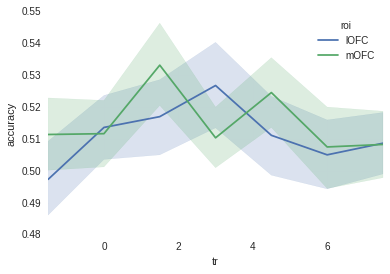

In [19]:
sns.tsplot(accuracy_df[accuracy_df['exp']=='ser'],unit='sub',time='tr',value='accuracy',condition='roi')

In [178]:
accuracy_df.to_csv('/home/iballard/fd/logistic.csv')

#Now run a searchlight

In [24]:
def load_data(sub,exp,timing):

    #load mask func
    mask_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/reg/epi/unsmoothed/run_1/functional_mask_xfm.nii.gz'
    mask_img = nib.load(mask_f)
    
    #load mean func (for use in getting image info)
    mean_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/reg/epi/unsmoothed/run_1/mean_func_xfm.nii.gz'
    mean_img = nib.load(mean_f)    
    
    X_data = []
    for run in range(1,4):
        func_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/reg/epi/unsmoothed/run_' + str(run) + '/timeseries_xfm.nii.gz'

        if os.path.exists(func_f):
            
            ts_img = nib.load(func_f)
            ts_data = ts_img.get_data()

            #get indices of events of interest and mask data
            indices = np.array(timing[timing['run']==run]['tr_index'].values,dtype=int)

            #deal with situation when scan is too short
            scan_dur = ts_data.shape[3]
            if scan_dur <= (indices[-1] + 4):
                
                print ' '.join([sub,exp,str(run)])
                
                #crop indices vector and take scans
                cropped_indices = [x for x in indices if (x + 4)<scan_dur]                

                #Drop unused entries from the timing dataframe
                while len(cropped_indices) < len(indices):
                    cropped_indices.append(np.NaN)
                timing.loc[timing['run']==run,'tr_index'] = cropped_indices
                timing = timing.dropna()
                
                indices = np.array([x for x in cropped_indices if not np.isnan(x)])

            #take 3 scans relative to the stimulus onset
            frame1 = ts_data[...,indices + 2]
            frame2 = ts_data[...,indices + 3]
            frame3 = ts_data[...,indices + 4]
            
            X_run = np.mean([frame1,frame2,frame3],axis=0) #average timepoints
            X_run = scipy.stats.zscore(X_run, axis = -1) #zscore
            X_data.append(X_run) #concatenate runs
        
        X = nib.Nifti1Image(np.concatenate(X_data,axis=-1), mean_img.get_affine(),
                           mean_img.get_header())
        y = map(lambda x: cond_map[x], timing['condition'].values)
        runs = timing['run'].values-1
        
    return mask_img, X, y, runs

In [25]:
def run_searchlight(sub,exp,radius,n_jobs):
    
    ##load timing and imaging data
    timing = get_event_times(sub,exp)
    mask_img, X, y, runs = load_data(sub,exp,timing)
    
    #fit searchlight
    searchlight = nilearn.decoding.SearchLight(mask_img = mask_img, radius = radius,
                                               estimator = LogisticRegression(),
                                               n_jobs = n_jobs, cv = LeaveOneLabelOut(runs))
    searchlight.fit(X,y)

    #write output
    mvpa_dir = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/mvpa/'
    if not os.path.exists(mvpa_dir):
        os.mkdir(mvpa_dir)
    out_f = mvpa_dir + 'searchlight_state_radius' + str(radius) + '.nii.gz'
    out_img = nib.Nifti1Image(searchlight.scores_,searchlight.mask_img.get_affine())
    out_img.to_filename(out_f)
    
    return


In [26]:
radius = 8
n_jobs = 5
for exp in ['ser','sim']:
    for sub in sub_list:
        #only run if haven't already run
        out_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/mvpa/searchlight_state_radius' + str(radius) + '.nii.gz'
        if not os.path.exists(out_f):
            run_searchlight(sub,exp,radius,n_jobs)

fd_109 sim 2


In [27]:
#Register to standard space
exp = 'sim'
radius = 8

for sub in sub_list:
    #set paths
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub
    mvpa_dir = sub_path + '/mvpa/'
    searchlight = mvpa_dir + 'searchlight_state_radius' + str(radius) + '.nii.gz'
    out_warp = mvpa_dir + 'searchlight_state_radius' + str(radius) + '_warp.nii.gz'

    if os.path.exists(searchlight) and not os.path.exists(out_warp):
    
        #register searchlight to anatomical space
        transform = sub_path + '/preproc/run_1/func2anat_tkreg.dat'
        out_rigid = mvpa_dir + 'searchlight_state_radius' + str(radius) + '_reg.nii.gz'
        if not os.path.exists(out_rigid):
            cmd_line = ['mri_vol2vol','--mov',searchlight,'--reg',transform,'--fstarg','--o',out_rigid,'--no-save-reg']
            os.system(' '.join(cmd_line))

        #warp to MNI
        ref_file = fsl.Info.standard_image("avg152T1_brain.nii.gz")
        affine = home_dir + '/data/' + sub + '/normalization/affine.txt'
        warpfield = home_dir + '/data/' + sub + '/normalization/warpfield.nii.gz'
        if not os.path.exists(out_warp):
            cmd_line = ['WarpImageMultiTransform','3',out_rigid,out_warp,warpfield,affine,'-R',ref_file]
            os.system(' '.join(cmd_line))

In [28]:
#take ttest accross subjects
exp = 'sim'
out_f = home_dir + '/searchlight_' + exp + '.nii.gz'
accs = []
for sub in sub_list: #load data
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub
    mvpa_dir = sub_path + '/mvpa/'
    out_warp = mvpa_dir + 'searchlight_state_radius' + str(radius) + '_warp.nii.gz'
    
    if os.path.exists(out_warp):
        data_f = nib.load(out_warp)
        accs.append(data_f.get_data())
accs = np.array(accs)
print accs.shape

#perform ttest and mask non-brain voxels
mask = accs.all(axis=0)
ts = scipy.stats.ttest_1samp(accs,.5,axis = 0)
ts = ts.statistic
ts[np.invert(mask)] = 0

#save result
out_img = nib.Nifti1Image(ts,data_f.get_affine(),data_f.get_header())
out_img.to_filename(out_f)

(34, 91, 109, 91)


In [33]:
#take PAIRED ttest accross subjects
out_f = home_dir + '/searchlight_paired.nii.gz'
accs = {'ser':[],'sim':[]}

for sub in sub_list: #load data
    for exp in exp_list:
        sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub
        mvpa_dir = sub_path + '/mvpa/'
        out_warp = mvpa_dir + 'searchlight_state_radius' + str(radius) + '_warp.nii.gz'

        if os.path.exists(out_warp):
            data_f = nib.load(out_warp)
            accs[exp].append(data_f.get_data())
accs['ser'] = np.array(accs['ser'])
accs['sim'] = np.array(accs['sim'])

#perform ttest and mask non-brain voxels
masks = {'ser':accs['ser'].all(axis=0),'sim':accs['sim'].all(axis=0)}
ts = scipy.stats.ttest_rel(accs['ser'],accs['sim'],axis = 0)
ts = ts.statistic
ts[np.invert(masks['ser'])] = 0
ts[np.invert(masks['sim'])] = 0

# #save result
out_img = nib.Nifti1Image(ts,data_f.get_affine(),data_f.get_header())
out_img.to_filename(out_f)

In [17]:
#do permutation testing correction for multiple comparisons
out_dir = home_dir + 'analysis/searchlight/'
radius = 8
out_f = out_dir + 'radus' + str(radius) + '_merged.nii.gz'
if not os.path.exists(out_f):

    merge_str = ['fslmerge','-t',out_f]
    for sub in sub_list: #subtract sim from ser
        out_im = out_dir + 'diff_' + sub + '.nii.gz'
        cmd_str = ['fslmaths']
        cmd_str.append(home_dir + 'analysis/ser_8mm/' + sub + '/mvpa/' 
                       + 'searchlight_state_radius' + str(radius) + '_warp.nii.gz')
        cmd_str.append('-sub')
        cmd_str.append(home_dir + 'analysis/sim_8mm/' + sub + '/mvpa/' 
                       + 'searchlight_state_radius' + str(radius) + '_warp.nii.gz')
        cmd_str.append(out_im)
        cmd_str = ' '.join(cmd_str)
        os.system(cmd_str)
        
        merge_str.append(out_im) #merge outputs

    merge_str =  ' '.join(merge_str)
    os.system(merge_str)

In [18]:
#perform permutation testing
cmd_str = ['randomise','-i',out_f,'-o',out_dir,'-T','-1','-n','1000']
cmd_str = ' '.join(cmd_str)
os.system(cmd_str)

0

#Perform surface based analysis

In [41]:
##register to surface
for sub in sub_list: #load data
    for exp in exp_list:
        #paths
        sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub
        mvpa_dir = sub_path + '/mvpa/'
        
        #relevant files
        vol_f = mvpa_dir + 'searchlight_state_radius' + str(radius) + '.nii.gz'
        reg_f = sub_path + '/preproc/run_1/func2anat_tkreg.dat'
        surf_f = [mvpa_dir + 'lh_state_radius' + str(radius) + '.mgz',
                 mvpa_dir + 'rh_state_radius' + str(radius) + '.mgz']
        #execute mrivol2surf for each hemisphere
        for i, hemi in enumerate(['lh','rh']):

            if not os.path.exists(surf_f[i]):

                cmd_str = ['mri_vol2surf','--mov',vol_f,'--reg',reg_f,'--trgsubject',
                           'fsaverage','--projfrac-avg','0','1','.1','--surf-fwhm','5',
                          '--hemi',hemi,'--o',surf_f[i]]
                os.system(' '.join(cmd_str))


In [12]:
subj_file = home_dir + 'subjects_filtered.txt'
sub_list = list(np.loadtxt(subj_file,'string'))

#take PAIRED ttest accross subjects
radius = 8
hemis = ['lh','rh']
accs = {'ser':[],'sim':[]}
accs = {'lh':accs,'rh':accs}
ts = {}
masks = {}

for hemi in hemis:
    out_f = home_dir + '/' + hemi + '_paired.mgz'
    for sub in sub_list: #load data
        for exp in exp_list:
            sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub
            mvpa_dir = sub_path + '/mvpa/'
            surf_f = mvpa_dir + hemi + '_state_radius' + str(radius) + '.mgz'
                      
            if os.path.exists(surf_f):
                data_f = nib.load(surf_f)
                accs[hemi][exp].append(data_f.get_data().squeeze())

for hemi in hemis:
    accs[hemi]['ser'] = np.array(accs[hemi]['ser'])
    accs[hemi]['sim'] = np.array(accs[hemi]['sim'])

    #perform ttest and mask non-brain voxels
    masks[hemi] = {'ser':accs[hemi]['ser'].all(axis=0),'sim':accs[hemi]['sim'].all(axis=0)}
    ts[hemi] = scipy.stats.ttest_rel(accs[hemi]['ser'],accs[hemi]['sim'],axis = 0)
    ts[hemi] = ts[hemi].statistic

In [13]:
alpha = .005
thresh = stats.t(34).ppf(alpha)*-1

In [14]:
views = dict()
for hemi in hemis:
    b = Brain("fsaverage", hemi, "inflated", config_opts={"background": "white", "width": 500, "height": 420})
    data = ts[hemi]
    data[ts[hemi] < thresh] = 0
    b.add_data(data, min=0.1, max=8, thresh=.1, colormap="OrRd_r", colorbar=False)
    b.show_view(dict(elevation=80,
                     azimuth=dict(lh=150, rh=30)[hemi],
                     focalpoint=[0, 10, 10]), distance=325)
#     label_f = home_dir + '/data/fsaverage/label/' + hemi + '.V1' + '.label'
#     b.add_label("BA1",borders=True)
    views[hemi] = b.screenshot()
    b.close()

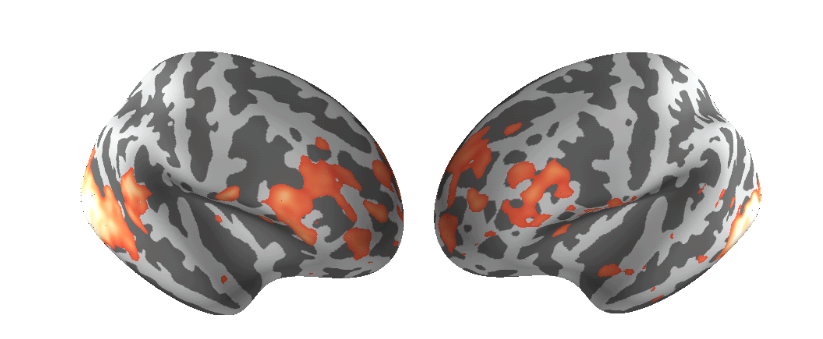

In [15]:
fig = plt.figure(figsize=(10, 10))

# Plot the average searchlights on the surface
rh_ax = fig.add_axes([-.04, .5, .54, .5])
rh_ax.imshow(views["rh"])
rh_ax.set_axis_off()
lh_ax = fig.add_axes([.5, .5, .54, .5])
lh_ax.imshow(views["lh"])
lh_ax.set_axis_off()

In [16]:
views = dict()
for hemi in hemis:
    b = Brain("fsaverage", hemi, "inflated", config_opts={"background": "white", "width": 500, "height": 420})
    data = ts[hemi]
    data[ts[hemi] < thresh] = 0
    b.add_data(data, min=0.1, max=8, thresh=.1, colormap="OrRd_r", colorbar=False)
    b.show_view('medial')
    views[hemi] = b.screenshot()
    b.close()

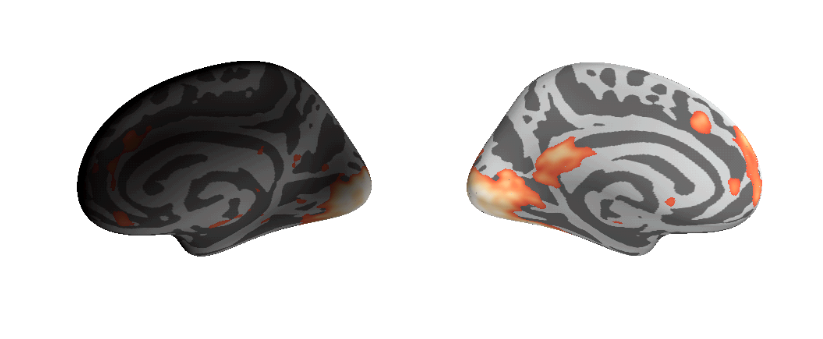

In [17]:
fig = plt.figure(figsize=(10, 10))

# Plot the average searchlights on the surface
rh_ax = fig.add_axes([-.04, .5, .54, .5])
rh_ax.imshow(views["rh"])
rh_ax.set_axis_off()
lh_ax = fig.add_axes([.5, .5, .54, .5])
lh_ax.imshow(views["lh"])
lh_ax.set_axis_off()